<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Проверка-данных-на-тестовой-выборке" data-toc-modified-id="Проверка-данных-на-тестовой-выборке-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка данных на тестовой выборке</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

В данном проекте поможем
компании «Чётенькое такси» построить модель, которая спрогнозирует количество заказов такси на следующий час. 

Необходимо чтобы значение метрики *RMSE* на тестовой выборке было не больше 48.

План работы:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, TimeSeriesSplit, cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


По умолчанию, данные отсортированы на каждые 10 минут. Разгруппируем данные по часам.

In [3]:
#Проводим ресемплирование данных по одному часу.
data = data.resample('1H').sum()
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные загружены, ресемплированы и подготовлены. Переходим к анализу.

In [4]:
display(data.index.is_monotonic)

True

Проверили и убедились, что датасет монотонен

## Анализ

In [5]:
def data_analysis(data):
    # проверка на наличие дубликатов
    if data.duplicated().sum() > 0:
        print("Количество дубликатов:", data.duplicated().sum())
    else:
        print("Дубликатов не найдено")
    
    # информация о типах данных и пропущенных значениях
    print("\nИнформация о типах данных и пропущенных значениях:")
    print(data.info())
    
    # статистические характеристики
    print("\nСтатистические характеристики:")
    print(data.describe())
data_analysis(data)

Количество дубликатов: 4165

Информация о типах данных и пропущенных значениях:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None

Статистические характеристики:
        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


В нашем распоряжении 4416 строк данных. Несмотря на то, что в в данных 4165 дубликатов, они не являются ложными или неправильными значениями, это статистическое значение количества заказов такси. Тип данных  *int64*.

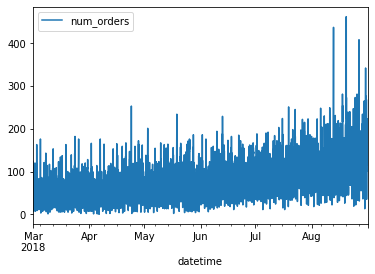

In [6]:
data.plot()
plt.show()

По данному графику можем заметить, что в нашем распоряжении 6 месяцев данных (март-август 2018). Заметно, что каждые несколько дней есть значительное увеличение количества заказов. Рассмотрим график поближе.

<AxesSubplot:xlabel='datetime'>

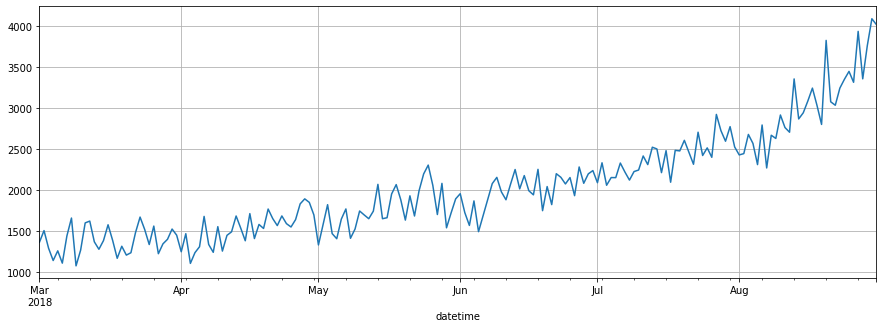

In [7]:
data['num_orders'].resample('D').sum().plot(figsize=(15, 5), grid=True)

Хорошо заметен восходящий тренд кол-ва заказов, старт с 1500 заказов в марте, достигает пика в конце августа - 4000 вызовов. Посмотрим на скользящее среднее

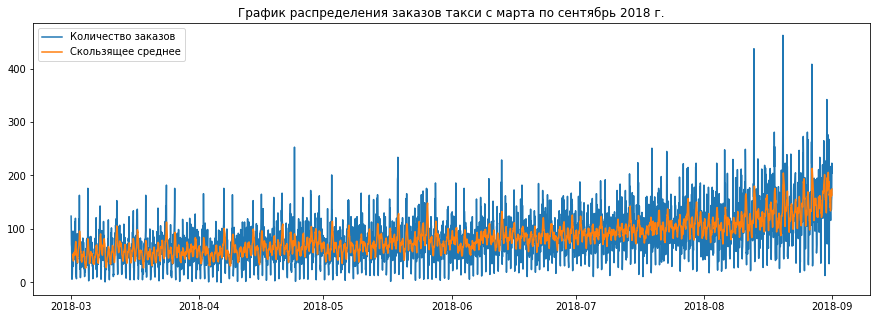

In [8]:
rolling_mean = data['num_orders'].rolling(window=10).mean()

plt.figure(figsize=(15,5))
plt.plot(data.index, data['num_orders'], label='Количество заказов')
plt.plot(rolling_mean.index, rolling_mean, label='Скользящее среднее')
plt.legend()
plt.title('График распределения заказов такси с марта по сентябрь 2018 г.')
plt.show()

График общей тенденции также показывает, что количество заказов такси растёт от марта к августу.

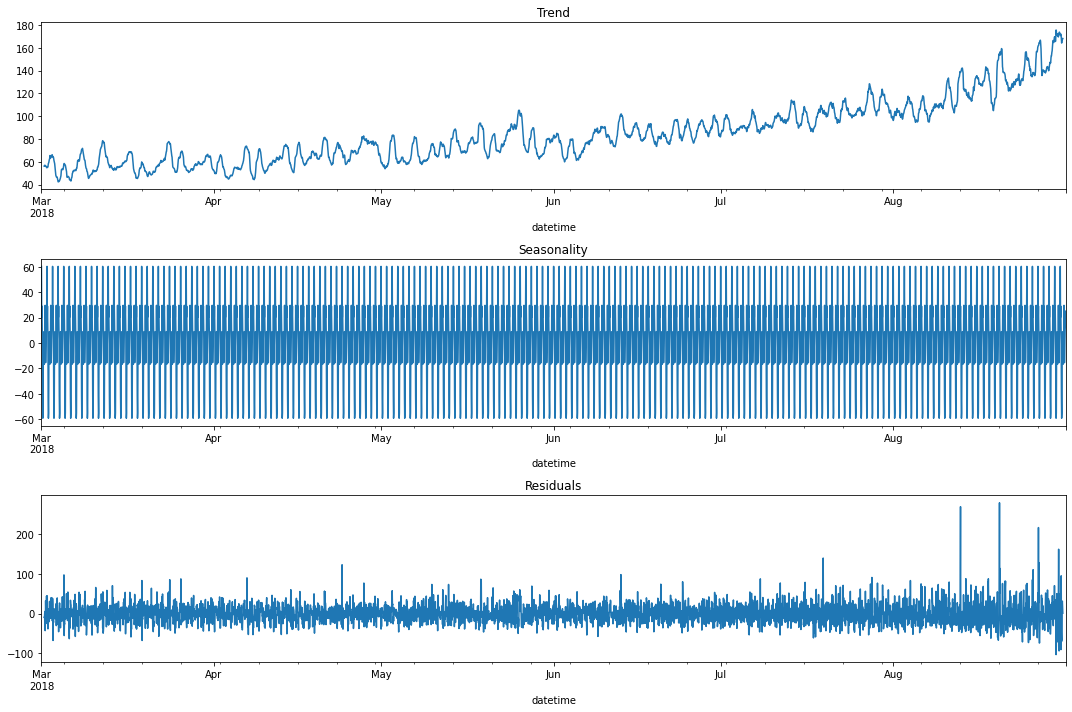

In [9]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15, 10))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
# < напишите код здесь >
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
# < напишите код здесь >
plt.title('Residuals')
plt.tight_layout()

Тренд показывает, что количество заказов увеличивается в летние месяцы. График нестационарный т.к. у него меняется среднее значение. График сезонности, в настоящий момент, необъясним. Рассмотрим первую и последнюю недели.

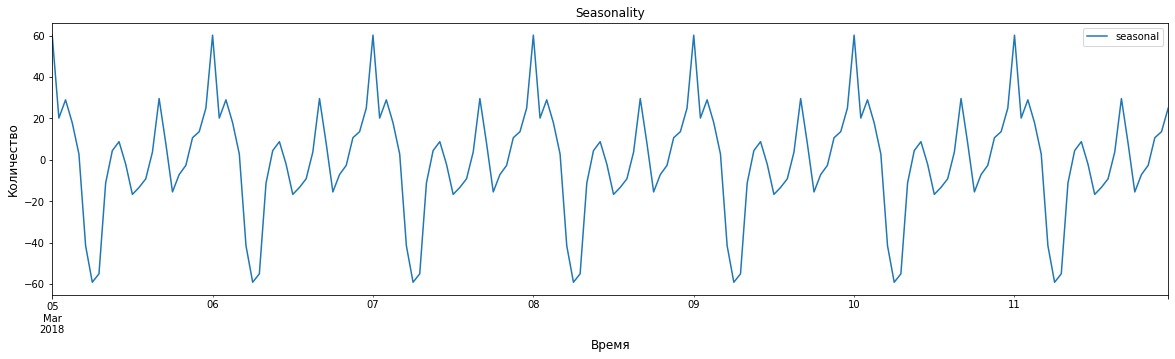

In [10]:
plt.figure(figsize=(20, 5))
decomposed.seasonal['2018-03-05':'2018-03-11'].plot(ax=plt.gca())
plt.xlabel('Время', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.legend()
plt.title('Seasonality')
plt.show()

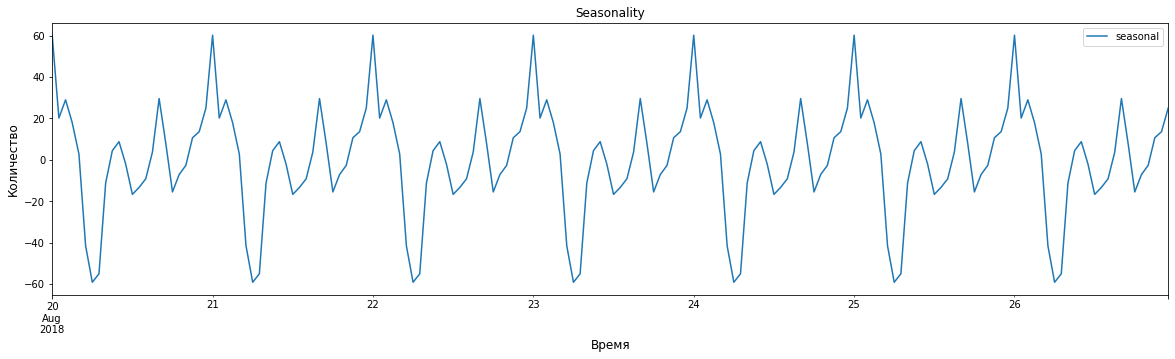

In [11]:
plt.figure(figsize=(20, 5))
decomposed.seasonal['2018-08-20':'2018-08-26'].plot(ax=plt.gca())
plt.xlabel('Время', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.legend()
plt.title('Seasonality')
plt.show()

Данные полностью повторяют друг друга. Даже на выходных можно заметить, что количесво заказов с утра похоже на любой будний день, в тоже время вечером, количество заказов значительно возврастает и падает ночью.

In [12]:
def add_features(data, lag_start=1, lag_end=24, rolling_mean_size=3):
    data = data.copy()
    # Создаем признаки даты и времени
    data['date'] = data.index.date
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # Добавляем отстающие значения
    for i in range(lag_start, lag_end + 1):
        data['lag_{}'.format(i)] = data['num_orders'].shift(i)
    
    # Добавляем скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(window=rolling_mean_size).mean()
       
    return data

In [13]:
data = add_features(data, 1, 24)

In [14]:
print(data.info())
print('')
print('************************************************')
print('')
print(data.head)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   date          4416 non-null   object 
 2   day_of_week   4416 non-null   int64  
 3   hour          4416 non-null   int64  
 4   lag_1         4415 non-null   float64
 5   lag_2         4414 non-null   float64
 6   lag_3         4413 non-null   float64
 7   lag_4         4412 non-null   float64
 8   lag_5         4411 non-null   float64
 9   lag_6         4410 non-null   float64
 10  lag_7         4409 non-null   float64
 11  lag_8         4408 non-null   float64
 12  lag_9         4407 non-null   float64
 13  lag_10        4406 non-null   float64
 14  lag_11        4405 non-null   float64
 15  lag_12        4404 non-null   float64
 16  lag_13        4403 non-null   float64
 17  lag_14        4402 non-null

Колонка "date" в исходных данных содержит только информацию о дате и времени, но не содержит дополнительной информации, такой как дни недели, месяцы и годы. Мы уже создали эти дополнительные колонки, кроме того тип колонки "date" object, поэтому данная колонка нам, в продолжении проекта, не нужна.

In [15]:
data = data.drop(['date'], axis=1)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   day_of_week   4416 non-null   int64  
 2   hour          4416 non-null   int64  
 3   lag_1         4415 non-null   float64
 4   lag_2         4414 non-null   float64
 5   lag_3         4413 non-null   float64
 6   lag_4         4412 non-null   float64
 7   lag_5         4411 non-null   float64
 8   lag_6         4410 non-null   float64
 9   lag_7         4409 non-null   float64
 10  lag_8         4408 non-null   float64
 11  lag_9         4407 non-null   float64
 12  lag_10        4406 non-null   float64
 13  lag_11        4405 non-null   float64
 14  lag_12        4404 non-null   float64
 15  lag_13        4403 non-null   float64
 16  lag_14        4402 non-null   float64
 17  lag_15        4401 non-null

Проанализировали датасет, добавили новые признаки (дни, дни недели, месяцы и год, а также лаги). Удалили лишние данные (date). Модель готова к обучению.

## Обучение

Разделяем данные на три части, и удаляем пропуски в тренировочной выборке.

In [16]:
train, test = train_test_split(data.copy(), shuffle=False, test_size=0.1)
#train, valid = train_test_split(train, shuffle=False, test_size=0.5)
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3950 entries, 2018-03-02 00:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    3950 non-null   int64  
 1   day_of_week   3950 non-null   int64  
 2   hour          3950 non-null   int64  
 3   lag_1         3950 non-null   float64
 4   lag_2         3950 non-null   float64
 5   lag_3         3950 non-null   float64
 6   lag_4         3950 non-null   float64
 7   lag_5         3950 non-null   float64
 8   lag_6         3950 non-null   float64
 9   lag_7         3950 non-null   float64
 10  lag_8         3950 non-null   float64
 11  lag_9         3950 non-null   float64
 12  lag_10        3950 non-null   float64
 13  lag_11        3950 non-null   float64
 14  lag_12        3950 non-null   float64
 15  lag_13        3950 non-null   float64
 16  lag_14        3950 non-null   float64
 17  lag_15        3950 non-null

Подготовим признаки

In [17]:
features_train  = train.drop('num_orders', axis=1)
target_train = train[['num_orders']]
features_test = test.drop('num_orders', axis=1)
target_test = test[['num_orders']]

Убедимся, что в выборках нет данных из будущего.

In [18]:
display(f'Временной отрезок обучающей выборки: {train.index.min()} - {train.index.max()}')
display(f'Временной отрезок тестовой выборки: {test.index.min()} - {test.index.max()}')

'Временной отрезок обучающей выборки: 2018-03-02 00:00:00 - 2018-08-13 13:00:00'

'Временной отрезок тестовой выборки: 2018-08-13 14:00:00 - 2018-08-31 23:00:00'

In [19]:
print("Размер обучающей выборки:", len(train))
print("Размер тестовой выборки:", len(test))
#print("Размер валидационной выборки:", len(valid))

Размер обучающей выборки: 3950
Размер тестовой выборки: 442


Проверка разбития данных. Условие задачи, оставить тестовую выборку размером 10% от исходных данных выполнена. Подготовим данные к масштабированию.

```python
features_train = train.drop(['num_orders'], axis=1)
features_valid = valid.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)

target_train = train['num_orders']
target_valid = valid['num_orders']
target_test = test['num_orders']
```

```python
scaler = StandardScaler()
scaler.fit(features_train)

features_train_scaled = scaler.transform(features_train)
features_valid_scaled = scaler.transform(features_valid)
features_test_scaled = scaler.transform(features_test)
```

Обученим модели: **LinearRegression, LGBMRegressor, XGBRegressor, CatBoostRegressor**

Для корректного оценивания качества модели на временных данных необходимо использовать кросс-валидацию с помощью TimeSeriesSplit. Воспользуемся значением фолдов равному восьми.

In [22]:
tscv = TimeSeriesSplit(n_splits=8)

Подготовим словарь для записи результатов RMSE.

In [23]:
# Запись оценок моделей
test_score = {}

Обучим линейную регрессию и посмотрим результат на валидационной выборке.

In [24]:
# обучение линейной регрессией
model = LinearRegression()

print(f'''Значение метрики RMSE на обучающей выборке для LinearRegression''', cross_val_score(model, features_train, target_train, 
                         cv = tscv, 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean())

Значение метрики RMSE на обучающей выборке для LinearRegression -27.07316416520977


In [25]:
# Запись оценок моделей
test_score['LinearRegression'] = [27.07]

```python
# обучение линейной регрессией
model = LinearRegression()

print(f'''Значение метрики RMSE на обучающей выборке для LinearRegression''', cross_val_score(model, features_train, target_train, 
                         cv = tscv, 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean())
```

Для обучения модели LGBMRegressor() найдём лучшие параметры с помощью GridSearchCV.  
**Update:** Параметры уже найдены и записаны в словарь.

```python

lgb_model = lgb.LGBMRegressor()


param_grid = {
    'num_leaves': [15, 31, 63],
    'max_depth': [3, 4, 5, -1],
    'learning_rate': [0.01, 0.1, 1],
   'n_estimators': [50, 100, 200]
}


grid_search = GridSearchCV(lgb_model, param_grid, cv=tscv, verbose=1)


grid_search.fit(features_train, target_train)


best_params = grid_search.best_params_
print('Лучшие параметры:', best_params)

```

In [26]:
lgbm_best_params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 15}

In [27]:
%time

lgb_model = lgb.LGBMRegressor(**lgbm_best_params)

# Обучаем модель на train
lgb_model.fit(features_train, target_train)

predictions = lgb_model.predict(features_train)

# Считаем RMSE
rmse_lgb = mean_squared_error(target_train, predictions)**0.5
print('LGBMRegressor RMSE:', rmse_lgb)

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 12.4 µs
LGBMRegressor RMSE: 17.05207897641072


In [28]:
# Запись оценок моделей
test_score['LGBMRegressor'] = [rmse_lgb]

В следующей ячейки отберём лучшие параметры для модели XGBRegressor().  

**Update:** данные найдены и записаны в словарь.

```python
xgb_model = XGBRegressor()


params = {'n_estimators': [50, 100, 150],
          'learning_rate': [0.1, 0.2, 0.3],
          'max_depth': [3, 4, 5],
          'min_child_weight': [1, 3, 5]}


grid_xgb = GridSearchCV(estimator=xgb_model, param_grid=params, cv=tscv)

grid_xgb.fit(features_train, target_train)


best_params = grid_xgb.best_params_
print("Лучшие гиперпараметры: ", best_params)
```

In [29]:
xgb_best_params = {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100}

In [30]:
%time
# Обучаем модель
model_xgb = XGBRegressor(**xgb_best_params, random_state=2023)
model_xgb.fit(features_train, target_train)

# Вычисляем RMSE
pred_xgb = model_xgb.predict(features_train)
rmse_xgb = mean_squared_error(target_train, pred_xgb) ** 0.5

print("XGBRegressor RMSE:", rmse_xgb)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs
XGBRegressor RMSE: 14.444568867777445


In [31]:
test_score['XGBRegressor'] = [rmse_xgb]

Обучим ещё одну модель CatBoostRegressor(). Найдем лучшие параметры с GridSearch и запишем в словарь.

```python
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'depth': [3, 5, 7],
    'iterations': [50, 100, 200]
}


cat_model = CatBoostRegressor()


grid_search = GridSearchCV(cat_model, param_grid, cv=tscv, verbose=1)

grid_search.fit(train_valid_features, train_valid_target, verbose=False)


best_params = grid_search.best_params_
print('Лучшие параметры:', best_params)
```

In [32]:
cat_best_params = {'depth': 7, 'iterations': 50, 'learning_rate': 0.01}

In [33]:
%time

cat_model = CatBoostRegressor(**cat_best_params, random_state=2023)

cat_model.fit(features_train, target_train, verbose=False)

pred_cat = cat_model.predict(features_train)

# Вычисляем RMSE
cat_rmse = mean_squared_error(target_train, pred_cat)**0.5
print("RMSE", cat_rmse)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
RMSE 31.538266194555725


In [34]:
test_score['CatBoostRegressor'] = [cat_rmse]

Обучили 4 модели, посмотрим на результаты 

In [35]:
df = pd.DataFrame.from_dict(test_score, orient='index', columns=['RMSE'])
display(df)

,RMSE
LinearRegression,27.070000
LGBMRegressor,17.052079
XGBRegressor,14.444569
CatBoostRegressor,31.538266


Все модели показали отличный результат на тренинговой выборке, но самый худший результат RMSE показала *CatBoostRegressor*. Таким образом будем продолжать тестировать *XGBRegressor* с результатом RMSE 14.44.

## Проверка данных на тестовой выборке

In [36]:
%time

# создаем и обучаем модель
best_model = XGBRegressor(**xgb_best_params, random_state=2023)
best_model.fit(features_train, target_train)

# делаем предсказание на тестовой выборке
pred_test = best_model.predict(features_test)

# считаем RMSE на тестовой выборке
best_rmse = mean_squared_error(target_test, pred_test)**0.5
print("RMSE на тестовой выборке для XGBRegressor:", best_rmse)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs
RMSE на тестовой выборке для XGBRegressor: 41.3747189438364


Посмотрим на пресказания модели в графическом виде. Возьмём данные за 2 дня (20-22 августа 2018 г.).  
Также для этого нам потребуется певести переменную *pred_test* в pandas Series.

In [37]:
pred_test = pd.Series(pred_test, index=target_test.index)

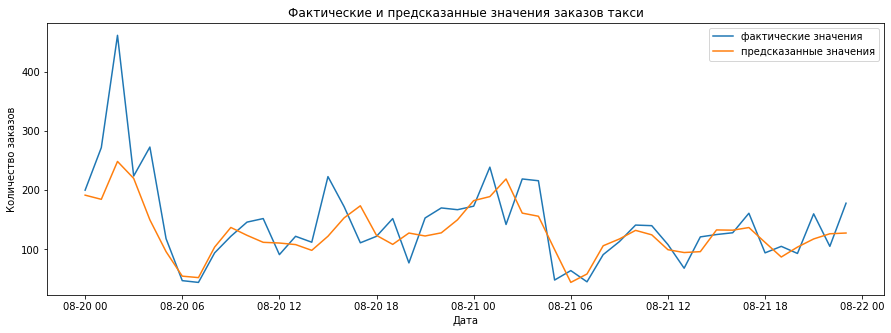

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))

start_date = '2018-08-20'
end_date = '2018-08-21'

ax.plot(target_test.loc[start_date:end_date].index, target_test.loc[start_date:end_date], label='фактические значения')
ax.plot(target_test.loc[start_date:end_date].index, pred_test.loc[start_date:end_date], label='предсказанные значения')

ax.set_title('Фактические и предсказанные значения заказов такси')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество заказов')
ax.legend()

plt.show()

В целом можно сказать, что модель угадывает, что количество заказов будет возврастать, хотя не может предугать точное количество вызовов. Но, в настоящий момент, модель **XGBRegressor**, самоё лучшее предложение для таксокомпании "Чётенькое Такси".

## Вывод

В данном проекте мы попытались помочь сервису "Четенькое такси", проанализировали данные за полгода, разделили заказы по одному часу. Провели анализ графиков, изучили тренд, сезонность, скользящее среднее. Обучили несколько моделей, выделили лучшую, проанализировали фактические и предсказанные значения заказов такси на модели XGBRegressor.

Рекомендуется использовать модель **XGBRegressor** для прогнозирования спроса на такси и использования её в сервисе "Чётенькое такси".

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48